# Kaggle - Outbrain Click Prediction
## Unveiling the secrets of page_views.csv and its relationship with events.csv

By [Gabriel S. P. Moreira](https://about.me/gspmoreira)

In this notebook, I leverage the power of a **Spark cluster** to explore the large (~88GB) page_views.csv dataset and analyze its relationshiop with events.csv in the [Kaggle - Outbrain Click Prediction challenge](https://www.kaggle.com/c/outbrain-click-prediction/) .  
We answer questions like: 

* **How to join page_views.csv and events.csv?**
* **Is events.csv a subset of page_views.csv?**
* **Are there additional page views for users in events.csv?**  


*If this Kaggle kernel helps you, don't forget to thumbs it up! ;)*

## Dependencies

* PySpark 2.0
* Pandas and Matplotlib - Only on master node

Just for reference, I am running this notebook on a Spark cluster with 1 master and 4 worker nodes (deployed on [Google Dataproc](http://cloud.google.com/dataproc/) ), each server with 4 CPUs and 16GB RAM.  
For some slower Spark transformations and actions, I've used the %time Jupyter magic command to log elapsed processing time.

# Analyzing page views

## Loading page_views.csv

In [102]:
from pyspark.sql.types import *
import pyspark.sql.functions as F

In [4]:
page_views_schema = StructType(
                    [StructField("uuid", StringType(), True),
                    StructField("document_id", IntegerType(), True),
                    StructField("timestamp", IntegerType(), True),
                    StructField("platform", IntegerType(), True),
                    StructField("geo_location", StringType(), True),
                    StructField("traffic_source", IntegerType(), True)]
                    )
#Data is read from Google Cloud Storage, a distributed filesystem like HDFS stored externally to the cluster
#If you wanna use your own HDFS, just prefix the file path with the absolute path 'hdfs:' or 
#with the relative path if HDFS is your cluster default filesystem
page_views_df = spark.read.schema(page_views_schema).options(header='true', inferschema='false', nullValue='\\N') \
                .csv("gs://sc-ml-hdfs-prd/tmp/outbrain/page_views.csv")

Spark sets the number of partitions based on file size, in this case, 708 partitions, each with about ~125MB. During job processing each partition becomes a task, which are processed in parallel by the available executors on Spark worker nodes.

In [6]:
page_views_df.rdd.getNumPartitions()

708

In [62]:
%time page_views_df.show()

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|1fd5f051fba643|        120| 31905835|       1|          RS|             2|
|8557aa9004be3b|        120| 32053104|       1|       VN>44|             2|
|c351b277a358f0|        120| 54013023|       1|       KR>12|             1|
|8205775c5387f9|        120| 44196592|       1|       IN>16|             2|
|9cb0ccd8458371|        120| 65817371|       1|   US>CA>807|             2|
|2aa611f32875c7|        120| 71495491|       1|       CA>ON|             2|
|f55a6eaf2b34ab|        120| 73309199|       1|       BR>27|             2|
|cc01b582c8cbff|        120| 50033577|       1|       CA>BC|             2|
|6c802978b8dd4d|        120| 66590306|       1|       CA>ON|             2|
|f4e423314303ff|        120| 48314254|       1|   US>LA>622|             1|
|3937372ca27

## Page views timestamp stats

In [9]:
%time page_views_timestamp_stats_df = page_views_df.describe('timestamp')

CPU times: user 60 ms, sys: 20 ms, total: 80 ms
Wall time: 5min 24s


In [10]:
page_views_timestamp_stats = page_views_timestamp_stats_df.rdd.collectAsMap()
page_views_timestamp_stats

{'count': '2034275448',
 'max': '1296000000',
 'mean': '6.51464604736012E8',
 'min': '0',
 'stddev': '3.809745454636914E8'}

**Total of page views available in this dataset**

In [170]:
page_views_count = int(page_views_timestamp_stats['count'])
print('# Page Views:',page_views_count)

# Page Views: 2034275448


** Page Views time range **

We can see below that dataset contains only page views between 2016-06-14 and 2016-06-28. As min and max timestamp in dataset are at about 4am, it suggests that dates are in UTC and the dataset days were filtered according to UTC-4 (Eastern Time - EST).   
To further model users preferences, it would be nice if we had in this dataset the full log of previous users pages visits, who had at least an event between that period (2016-06-14 and 2016-06-28).

In [12]:
from datetime import datetime
def convert_odd_timestamp(timestamp_ms_relative):
    TIMESTAMP_DELTA=1465876799998
    return datetime.fromtimestamp((int(timestamp_ms_relative)+TIMESTAMP_DELTA)//1000)

In [218]:
print(convert_odd_timestamp(page_views_timestamp_stats['min']))

2016-06-14 03:59:59


In [219]:
print(convert_odd_timestamp(page_views_timestamp_stats['max']))

2016-06-29 03:59:59


## Page views by user

In [77]:
import pandas as pd

In [15]:
#Grouping page views by user id and aggregating the count by user
page_views_by_user_df = page_views_df.groupBy('uuid').count()

In [16]:
#Grouping page views user counts by counts (to build a histogram)
page_views_user_distribution_df = page_views_by_user_df.select('count').groupby('count').count()

In [17]:
#Converting the PySpark Dataframe to a Pandas Dataframe (for plotting)
%time page_views_by_user_pandas = page_views_user_distribution_df.toPandas()

CPU times: user 412 ms, sys: 88 ms, total: 500 ms
Wall time: 16min 4s


In [32]:
len(page_views_by_user_pandas)

563

This table shows that 458234809 users have only 1 page view in the dataset, 94245789 have exactly 2 page views (94245789), etc.

In [47]:
page_views_by_user_pandas.columns = ['pageViewsByUser', 'usersCount']
page_views_by_user_pandas = page_views_by_user_pandas.set_index('pageViewsByUser').sort_index()
page_views_by_user_pandas.head(10)

,usersCount
pageViewsByUser,
1,458234809
2,94245789
3,44977389
4,26869230
5,17942534
6,12878964
7,9691732
8,7573614
9,6036047


**Total number of distinct users in page views**

In [167]:
distinct_users_count = page_views_by_user_pandas['usersCount'].sum()
distinct_users_count

717506889

The **Average page views by user** indicates that we have higher average (**2.835**) in **page views** dataset, when compared to the **events dataset** (**1.167**).

In [171]:
avg_page_views_by_user = page_views_count / float(distinct_users_count)
avg_page_views_by_user

2.8351998833561027

Plotting the number of users (y axis) by the count of their page views (x axis). We can see that most users (458234809 ~ 5*10^8) have only 1 page view during the period.

In [51]:
%matplotlib inline

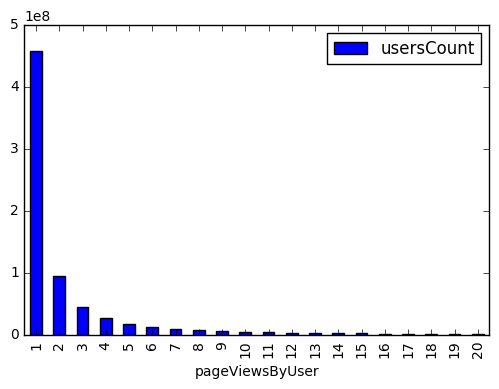

In [53]:
page_views_by_user_pandas.head(20).plot.bar(y='usersCount')

Calculating the cumulative percentual of users with at most N page views

In [49]:
page_views_by_user_pandas['cum_perc'] = (page_views_by_user_pandas['usersCount'].cumsum() / distinct_users_count) * 100

In [50]:
page_views_by_user_pandas.head(10)

,usersCount,cum_perc
pageViewsByUser,,
1,458234809,63.864865
2,94245789,77.000041
3,44977389,83.268606
4,26869230,87.013411
5,17942534,89.514088
6,12878964,91.309049
7,9691732,92.659800
8,7573614,93.715346
9,6036047,94.556598


In cumulative chart, we can see that 65% of the users have only 1 page view, 77%, have at most 2 page views and 89% of the users have at most 5 page views. 

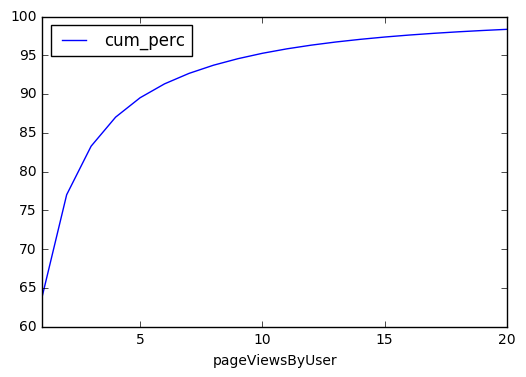

In [52]:
page_views_by_user_pandas.head(20).plot.line(y='cum_perc')

In the long tail, we can see there are users with more than 600 page views during that period!

In [168]:
page_views_by_user_pandas.tail(10)

,usersCount,cum_perc
pageViewsByUser,,
668,2,99.999999
675,1,99.999999
677,1,99.999999
684,1,99.999999
696,1,99.999999
703,1,99.999999
704,1,100.000000
718,1,100.000000
811,1,100.000000


## Page views by Platform

In [181]:
%time page_views_by_platform_pandas = page_views_df.groupBy('platform').count().toPandas()

CPU times: user 52 ms, sys: 16 ms, total: 68 ms
Wall time: 5min 26s


In [182]:
page_views_by_platform_pandas = page_views_by_platform_pandas.set_index('platform').sort_index()
page_views_by_platform_pandas

,count
platform,
1,790149483
2,1053365944
3,190760021


**Distribution of page views by platform**

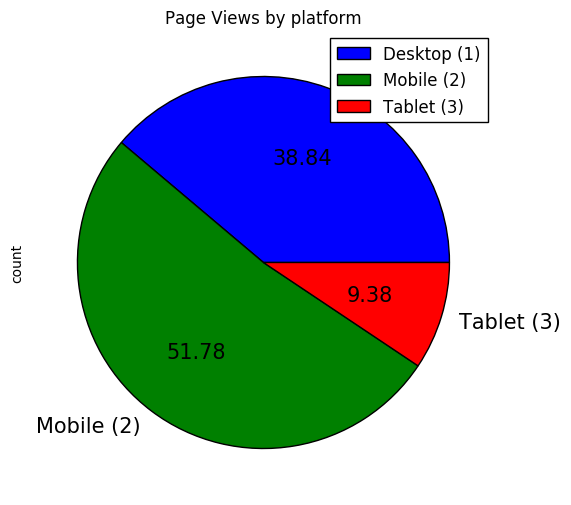

In [183]:
page_views_by_platform_pandas.plot.pie(y='count', figsize=(6, 6), labels=['Desktop (1)', 'Mobile (2)', 'Tablet (3)'], 
              title='Page Views by platform', autopct='%.2f', fontsize=15)

## Page views by Traffic Source

In [184]:
%time page_views_by_traffic_source_pandas = page_views_df.groupBy('traffic_source').count().toPandas()

CPU times: user 40 ms, sys: 124 ms, total: 164 ms
Wall time: 5min 26s


In [185]:
page_views_by_traffic_source_pandas = page_views_by_traffic_source_pandas.set_index('traffic_source').sort_index()
page_views_by_traffic_source_pandas

,count
traffic_source,
1,1293550863
2,343133832
3,397590753


**Distribution of page views by traffic source**

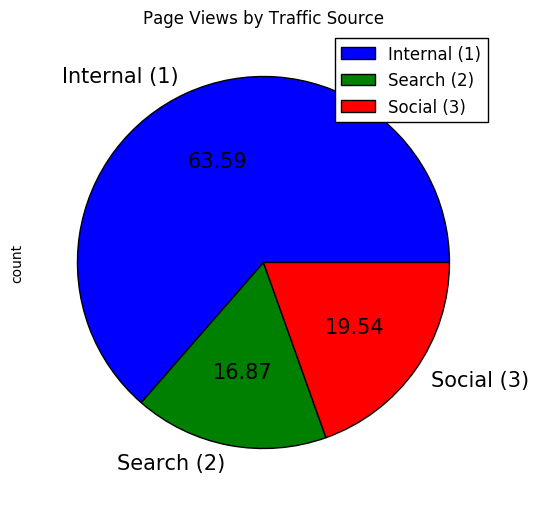

In [186]:
page_views_by_traffic_source_pandas.plot.pie(y='count', figsize=(6, 6), labels=['Internal (1)', 'Search (2)', 'Social (3)'], 
              title='Page Views by Traffic Source', autopct='%.2f', fontsize=15)

## Users visiting a page more than once

Surprisingly, there are **47937415 repeated combinations of users visiting a page more than once**.

In [187]:
page_views_by_user_doc_df = page_views_df.groupBy(['uuid','document_id']).count().alias('count').filter('count > 1')
page_views_by_user_doc_df.count()

47937415

In [188]:
page_views_by_user_doc_df.show(10)

+--------------+-----------+-----+
|          uuid|document_id|count|
+--------------+-----------+-----+
|6a5618eba26990|      25529|    2|
|571016386ffee7|      25792|    6|
|6a91157d820e37|      25792|    6|
|2aec87c28309c5|      25792|    2|
|b97961739d2f29|      25792|    2|
|a743b03f2b8ddc|      25792|    3|
|8d87becfb35857|      25792|    4|
|6d82e412aa0f0d|      25792|    8|
|ad45fc764587b0|      25792|    6|
|29ebac4412da91|      25792|    2|
+--------------+-----------+-----+
only showing top 10 rows



If we sample one of those repeated combinations, we observe a user which has visited the same page in 6 different days...

In [190]:
page_views_df.filter('uuid="571016386ffee7" and document_id=25792').show()

+--------------+-----------+---------+--------+------------+--------------+
|          uuid|document_id|timestamp|platform|geo_location|traffic_source|
+--------------+-----------+---------+--------+------------+--------------+
|571016386ffee7|      25792| 49576389|       1|   US>MO>616|             1|
|571016386ffee7|      25792|120316675|       1|   US>MO>616|             1|
|571016386ffee7|      25792|576124810|       1|   US>MO>616|             1|
|571016386ffee7|      25792|639792203|       1|   US>MO>616|             1|
|571016386ffee7|      25792|724651242|       1|   US>MO>616|             1|
|571016386ffee7|      25792|817713829|       1|   US>MO>616|             1|
+--------------+-----------+---------+--------+------------+--------------+



In [217]:
for ts in [49576389, 120316675, 576124810, 639792203, 724651242, 817713829]:
    print(convert_odd_timestamp(ts))

2016-06-14 17:46:16
2016-06-15 13:25:16
2016-06-20 20:02:04
2016-06-21 13:43:12
2016-06-22 13:17:31
2016-06-23 15:08:33


# Exploring relationship with Events

## Loading events.csv

In this section we explore Page Views and Events relationship.

In [66]:
events_schema = StructType(
                    [StructField("display_id", IntegerType(), True),
                    StructField("uuid", StringType(), True),
                    StructField("document_id", IntegerType(), True),
                    StructField("timestamp", IntegerType(), True),
                    StructField("platform", IntegerType(), True),
                    StructField("geo_location", StringType(), True)]
                    )

events_df = spark.read \
            .schema(events_schema) \
            .options(header='true', inferschema='false', nullValue='\\N') \
            .csv("gs://sc-ml-hdfs-prd/tmp/outbrain/events.csv").cache()

In [67]:
events_df.rdd.getNumPartitions()

10

In [69]:
events_df.show()

+----------+--------------+-----------+---------+--------+------------+
|display_id|          uuid|document_id|timestamp|platform|geo_location|
+----------+--------------+-----------+---------+--------+------------+
|         1|cb8c55702adb93|     379743|       61|       3|   US>SC>519|
|         2|79a85fa78311b9|    1794259|       81|       2|   US>CA>807|
|         3|822932ce3d8757|    1179111|      182|       2|   US>MI>505|
|         4|85281d0a49f7ac|    1777797|      234|       2|   US>WV>564|
|         5|8d0daef4bf5b56|     252458|      338|       2|       SG>00|
|         6|7765b4faae4ad4|    1773517|      395|       3|   US>OH>510|
|         7|2cc3f6457d16da|    1149661|      602|       2|   US>MT>762|
|         8|166fc654d73c98|    1330329|      638|       2|   US>PA>566|
|         9|9dddccf70f6067|    1772126|      667|       1|   US>FL>528|
|        10|b09a0e92aa4d17|     157455|      693|       1|          US|
|        11|602e210c5831e5|    1773230|      710|       3|   US>

**Events count**

In [68]:
%time events_count = events_df.count()
events_count

CPU times: user 4 ms, sys: 4 ms, total: 8 ms
Wall time: 27.8 s


23120126

**Distinct users in events**

In [220]:
%time distinct_events_users = events_df.agg(F.countDistinct("uuid").alias('count')).collect()[0]['count']
distinct_events_users

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 5.97 s


19794967

**Average events by user**

In [191]:
avg_events_by_user = events_count / float(distinct_events_users)
avg_events_by_user

1.1679800223966021

**Creating a dummy columns on Page Views and Events datasets, which will be useful to filter matches in outer joins**

When joining DataFrames, the resulting DataFrame keeps only one column for each of the join fields. Thus, we've included dummy columns (dummyPageView, dummyEvent) on each dataset to be able to identify rows where there is a match (both dummy columns filled). Otherwise, only one of dummy columns will be filled and the other will be None (because its an outer join).

In [192]:
page_views_df = page_views_df.withColumn('dummyPageView', F.lit(1))
events_df = events_df.withColumn('dummyEvent', F.lit(1))

### Performing a join between page views and events, on fields uuid and document_id

Here we perform an outer join between page_views.csv and events.csv datasets, on uuid and document_id fields. The objective is to explore rows matches, and see if events dataset subset is a subset of page views.  

In [193]:
page_views_events_joined_by_uuid_document_df = page_views_df.alias('page_views').join(events_df.alias('events'), on=['uuid','document_id'], how='outer')

Count of events without a match on page views (0). We can see that all combinations of (uuid, document_id) events are represented on page views dataset.

In [194]:
%time page_views_events_joined_by_uuid_document_df.filter('dummyEvent is not null and dummyPageView is null').count()

CPU times: user 164 ms, sys: 16 ms, total: 180 ms
Wall time: 16min 20s


0

In the matches (uuid, document_id) table below, we can see that for (uuid=10012c47f7317b, document_id=2897953) there are two records on Page Views (left side), but only one record in Events (right side), repeated with display_id=21485757.  
As the fields platform (3) and geo_location (US>CO>751) are also equal, this suggests that **timestamp is important when joining page views and events, as the user might visit a page more than once, at different times**.

In [76]:
page_view_events_matches_df = page_views_events_joined_by_uuid_document_df 
                        .filter('dummyPageView is not null and dummyEvent is not null')
%time page_view_events_matches_df.show(200)

+--------------+-----------+----------+--------+------------+--------------+----------+----------+--------+------------+
|          uuid|document_id| timestamp|platform|geo_location|traffic_source|display_id| timestamp|platform|geo_location|
+--------------+-----------+----------+--------+------------+--------------+----------+----------+--------+------------+
|100025359c1e4b|     542474| 239288958|       3|          ZA|             1|   3749002| 239293893|       3|          ZA|
|10003a00054aa3|     573399| 252875434|       2|   US>MA>506|             1|   3972594| 252875434|       2|   US>MA>506|
|10012c47f7317b|    2897953|1212693052|       3|   US>CO>751|             1|  21485757|1207434141|       3|   US>CO>751|
|10012c47f7317b|    2897953|1207434141|       3|   US>CO>751|             1|  21485757|1207434141|       3|   US>CO>751|
|10013cf2933dd1|    2287664| 636931394|       1|   US>MO>609|             1|   9359025| 636931394|       1|   US>MO>609|
|10031b0b19b6a6|    1984874| 339

## Performing a join between page views and events, on fields uuid, document_id, platform, and geo_location

Here we left join events and page views datasets on uuid, document_id, platform, and geo_location.  
There are **26323644** rows in the joined dataset, but events dataset has fewer rows (**23120126**) suggesting that those four fields does not uniquely join the datasets, because some events rows are duplicated to match page views.

In [142]:
%time events_with_day_df.alias('events').join(page_views_with_day_df.alias('page_views'),
                                              on=['uuid','document_id','platform','geo_location'], how='left') \
                                        .count()

CPU times: user 176 ms, sys: 48 ms, total: 224 ms
Wall time: 21min 45s


26323644

## Performing a join between page views and events, on fields uuid, document_id and timestamp

Let's try to join datasets now considering uuid, document_id and timestamp

In [197]:
page_views_events_joined_by_uuid_document_timestamp_df  = events_df.alias('events') \
                                                            .join(page_views_df.alias('page_views'), 
                                                                   on=['uuid','document_id','timestamp'], 
                                                                   how='left')

We can see that joining on those 3 fields we have **15854250** matches. This is only **68%** of the total **23120126** events, so **timestamps between page views and events appears not to be exactly aligned**.

In [198]:
%time page_views_events_joined_by_uuid_document_timestamp_df.filter('dummyEvent is not null and dummyPageView is not null').count()

CPU times: user 168 ms, sys: 24 ms, total: 192 ms
Wall time: 17min 47s


15854250

## Analyzing delta between page views and events timestamps

We've built a User Defined Function (UDF) to calculate the delta seconds between page views and events timestamps

In [104]:
diff_between_page_views_events_timestamps_udf = F.udf(lambda event_ts, page_view_ts: round(abs((convert_odd_timestamp(event_ts) - convert_odd_timestamp(page_view_ts)).total_seconds())), IntegerType())

We use again the matching rows of joined dataset only on (uuid, document_id) fields, to analyze the statistics of  timestamp delta (in seconds) between the two datasets. We can see that the **average (arithmetic mean) delta between timestamps is 49323 seconds (13.7 hours)**. 

In [107]:
page_view_events_matches_with_delta_ts_df = page_view_events_matches_df \
                                        .withColumn('timestamp_delta_secs', diff_between_page_views_events_timestamps_udf('events.timestamp', 'page_views.timestamp')) \
                                        .select('timestamp_delta_secs')
%time page_view_events_matches_with_delta_ts_df.describe('timestamp_delta_secs').show()

CPU times: user 172 ms, sys: 48 ms, total: 220 ms
Wall time: 17min 47s
+-------+--------------------+
|summary|timestamp_delta_secs|
+-------+--------------------+
|  count|            26750921|
|   mean|   49323.24790279183|
| stddev|   159902.2796012831|
|    min|                   0|
|    max|             1295724|
+-------+--------------------+



As arithmetic mean are very sensitive to large outliers, we analyze the distribution using quantiles.
We can see that at least 50% (median) of matching rows on (uuid, document_id) have a delta of 0 seconds (identical), but at 75% quantile we have samples with a delta of around 211 seconds (3.5 min).  
I guess one possible source of these differences might be that, for some platforms or providers, a page view is logged on page load, and then, after some time in that browser tab, the user clicks in one ad, and a display_id is logged in events dataset with a newer timestamp.

In [195]:
quantiles_levels = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.75]        
%time quantiles = page_view_events_matches_with_delta_ts_df.approxQuantile("timestamp_delta_secs", quantiles_levels, 0.05)
list(zip(quantiles_levels, quantiles))

CPU times: user 208 ms, sys: 36 ms, total: 244 ms
Wall time: 18min 15s


[(0.25, 0.0),
 (0.3, 0.0),
 (0.35, 0.0),
 (0.4, 0.0),
 (0.45, 0.0),
 (0.5, 0.0),
 (0.75, 211.0)]

## Performing the join on fields uuid, document_id, platform, geo_location and day(timestamp)

As we have a delta between page views and events timestamps, we extract the dates from timestamps (ignoring hours) from both datasets

In [130]:
truncate_day_from_timestamp_udf = F.udf(lambda ts: int(ts / 1000 / 60 / 60 / 24), IntegerType())

In [136]:
page_views_with_day_df = page_views_df.withColumn('day', truncate_day_from_timestamp_udf('timestamp')).withColumn('dummyPageView', F.lit(1))

In [137]:
events_with_day_df = events_df.withColumn('day', truncate_day_from_timestamp_udf('timestamp')).withColumn('dummyEvent', F.lit(1))

**Now we join the datasets on fields uuid, document_id, platform, geo_location and day(timestamp).  
This join approach appears to be reasonable, because there are 23120126 resulting rows (exactly the events count, with no duplication) and the count of rows where events have no corresponding page view is 55568 (only 0.24% of events)**  

In [138]:
page_views_events_with_day_joined_df = events_with_day_df.alias('events').join(page_views_with_day_df.alias('page_views'), on=['uuid','document_id','platform','geo_location','day'], how='left')

In [134]:
%time page_views_events_with_day_joined_df.count()

CPU times: user 376 ms, sys: 104 ms, total: 480 ms
Wall time: 32min 26s


23120126

Probably this relatively few events (0.24% of events) not matching any page view in the same day are due to possible page view and events timestamps around 4am (midnight at Eastern time) being splits in different days, even if delta between them is just some minutes.

In [139]:
events_without_matching_page_views_on_same_day_df = page_views_events_with_day_joined_df \
                                            .filter('page_views.dummyPageView is null')
%time events_without_matching_page_views_on_same_day_df.count()

CPU times: user 360 ms, sys: 128 ms, total: 488 ms
Wall time: 33min 29s


55568

## Analyzing users' additional page views not in events

The main reason for the usage of page views dataset is that it might provide additional user logs when compaired to events dataset, that could help us to model users preferences or interests. Let's test this hypothesis.

In [229]:
#Registering events dataset as a view, to use it in a SQL query
events_with_day_df.createOrReplaceTempView("EVENTS")    

#Registering "page_views left join events dataset" as a view, to use it in a SQL query
page_views_left_join_events_df = page_views_with_day_df.alias('page_views') \
                                        .join(events_with_day_df.alias('events'), 
                                              on=['uuid','document_id','platform','geo_location','day'], 
                                              how='left')
page_views_left_join_events_df.createOrReplaceTempView("PAGE_VIEWS_LEFT_JOIN_EVENTS")

#Grouping how many users have exactly N additional page views (which are not in events dataset, 
#                                                              but only from users in events dataset)
additional_page_views_by_user_df = spark.sql('''
            SELECT additionalPageViewsByUser, COUNT(*) as usersCount FROM
                (SELECT UUID, COUNT(*) as additionalPageViewsByUser 
                FROM PAGE_VIEWS_LEFT_JOIN_EVENTS p 
                WHERE dummyEvent IS NULL
                  AND EXISTS (SELECT uuid FROM EVENTS where uuid = p.uuid) 
                GROUP BY UUID)
            GROUP BY additionalPageViewsByUser''')

In this table, we show that **2288031 users have only 1 additional page view** (which is not in events dataset), **1654220 users have exactly 2 additional page views**, etc.

In [230]:
%time additional_page_views_by_user_pandas = additional_page_views_by_user_df.toPandas()
additional_page_views_by_user_pandas = additional_page_views_by_user_pandas.set_index('additionalPageViewsByUser').sort_index()
additional_page_views_by_user_pandas.head(10)

CPU times: user 368 ms, sys: 88 ms, total: 456 ms
Wall time: 27min 19s


,count
additionalPageViewsByUser,
1,2288031
2,1654220
3,1288044
4,1049242
5,872857
6,742933
7,641927
8,559609
9,493910


** There are 14951413 (about 75%) users in events dataset which have at least one additional page view (besides the ones logged as events), and 4843554 (about 25%) users with no additional page view. **

In [233]:
users_with_additional_page_views_count = additional_page_views_by_user_pandas['usersCount'].sum()
users_with_additional_page_views_count

14951413

In [234]:
users_without_additional_page_view = distinct_events_users - users_with_additional_page_views_count
users_without_additional_page_view

4843554

**Below it can be seen an histogram drawing a beautiful Poisson distribution of the users count with at least one additional page view.**

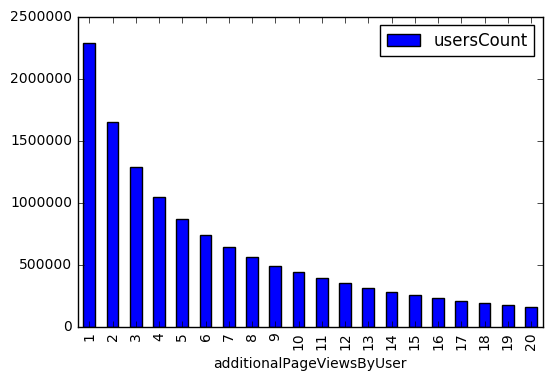

In [199]:
additional_page_views_by_user_pandas.head(20).plot.bar(y='usersCount')

**Users count cumulative percentage (users with at least one additional page view)**

In [208]:
additional_page_views_by_user_pandas['cum_perc'] = (additional_page_views_by_user_pandas['usersCount'].cumsum() / users_with_additional_page_views_count) * 100
additional_page_views_by_user_pandas.head(10)

,usersCount,cum_perc
additionalPageViewsByUser,,
1,2288031,15.303109
2,1654220,26.367080
3,1288044,34.981945
4,1049242,41.999622
5,872857,47.837579
6,742933,52.806561
7,641927,57.099981
8,559609,60.842831
9,493910,64.146265


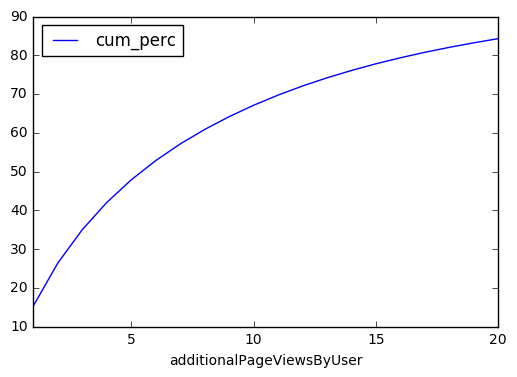

In [209]:
additional_page_views_by_user_pandas.head(20).plot.line(y='cum_perc')

Some outlier users with more than 500 additional page views...

In [228]:
additional_page_views_by_user_pandas.tail(10)

,usersCount,cum_perc
additionalPageViewsByUser,,
541,1,99.999940
546,1,99.999946
553,1,99.999953
560,1,99.999960
618,1,99.999967
635,1,99.999973
654,1,99.999980
656,1,99.999987
676,1,99.999993


# Conclusion

**In this notebook, we leveraged the processing power of a Spark cluster, and explored page_views.csv dataset and its relationship with events.csv dataset.  
We discovered that fields (uuid, document_id, platform, geo_location and day(timestamp)) can be used to effectivelly join both datasets. And events dataset can be considered to be a subset of page_views dataset, as almost all (99.76%) its rows can be matched in page_views.csv using these fields.  
We also discovered that 75% of users in events.csv have additional logged visits on page_views.csv, which hopefully might be used to model users preferences for personalized ads ranking.**